In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import scipy.sparse as sparse
import sklearn.metrics as metrics
import sys as sys
import skimage
import PIL
import sklearn.mixture as mixture
import math

/Users/tyyoo/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
from skimage import data,io

In [58]:
import os
pthname = './CS281 TestDataSet/VESICLE/VESICLE snr 7 density low/'
fname_list = [pthname+'VESICLE snr 7 density low t%03d z0.tif' %n for n in range(100) ]
imgs = {}
for i,fname in enumerate(fname_list):
    imgs[i] = np.array(io.imread(fname),dtype=float)

In [59]:
%%time
from skimage import feature
thres = np.mean(imgs[0])
A = feature.blob_log(imgs[0],threshold=10)

CPU times: user 1.79 s, sys: 76 ms, total: 1.87 s
Wall time: 1.9 s


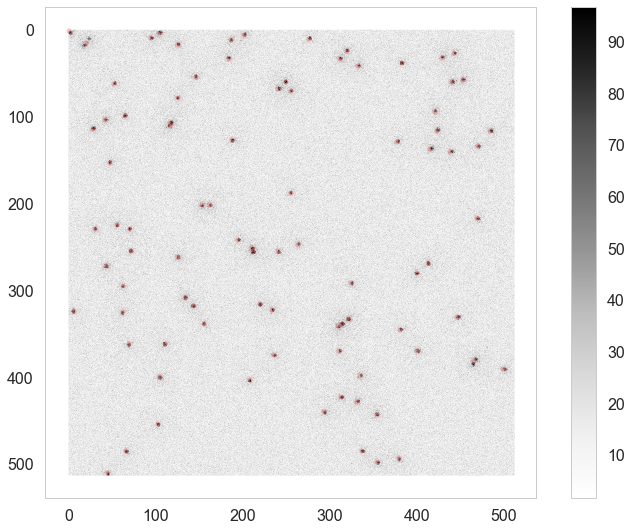

In [60]:
io.imshow(imgs[0],cmap='Greys')
plt.scatter(A[:,1],A[:,0],20,color='r',alpha=0.2)
plt.grid(False)

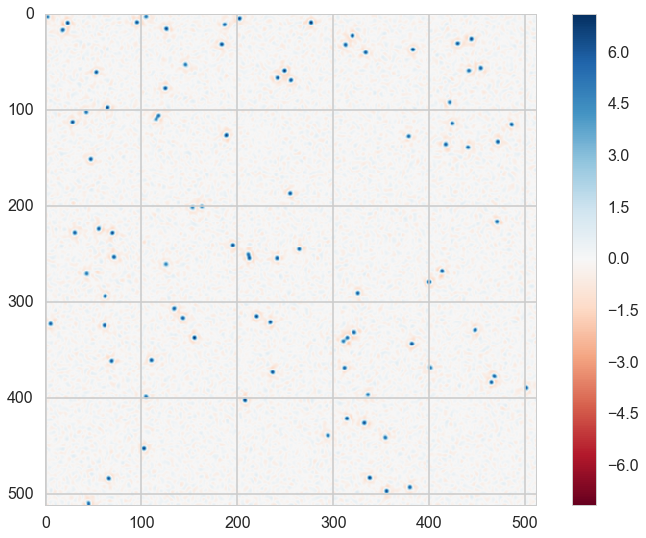

In [61]:
filtered = -sp.ndimage.filters.gaussian_laplace(imgs[0],2)
io.imshow(filtered)


In [62]:
c = 3
thres = (np.mean(filtered)+c)*np.std(filtered)
thres_filtered = filtered-thres
thres_filtered[thres_filtered<0] = 0 
#io.imshow(thres_filtered)
grad_filtered = np.gradient(filtered)
#np.min(np.abs(grad_filtered))

In [63]:
zero_crossings = np.where((np.diff(np.sign(grad_filtered[0]),axis=0)<0)[:511,:511] & (np.diff(np.sign(grad_filtered[1]),axis=1)<0)[:511,:511])

zero_crossing_x = np.array([])
zero_crossing_y = np.array([])
for y,x in zip(zero_crossings[0],zero_crossings[1]):
    if thres_filtered[y,x]>0:
        zero_crossing_x = np.append(zero_crossing_x,[x])
        zero_crossing_y = np.append(zero_crossing_y,[y])

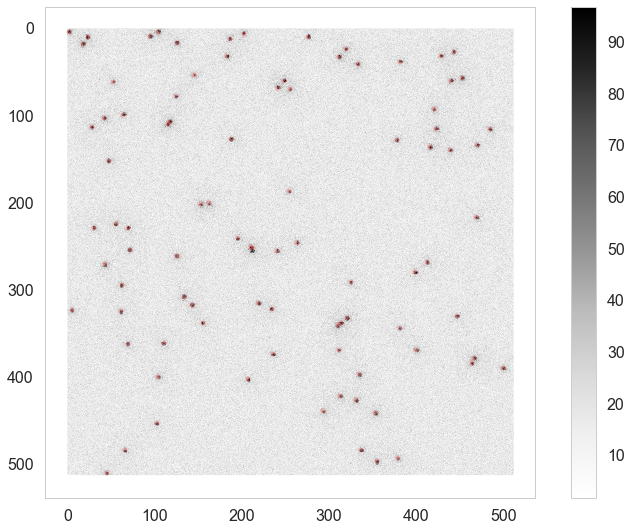

In [64]:
io.imshow(imgs[0],cmap='Greys')
plt.scatter(zero_crossing_x,zero_crossing_y,20,color='r',alpha=0.2)
plt.grid(False)

In [65]:
def SpotEnhancingFilterLocalization(imgs,c=4):
    #bottom-localization via the Spot-Enhancing Filter
    #input:
    # imgs - dictionary of fr#:img
    # c - constant that determines the threshold level
    ysefx = {}
    ysefy = {}

    for fr in imgs.keys():
        img = imgs[fr]
        filtered = -sp.ndimage.filters.gaussian_laplace(img,2)

        thres = (np.mean(filtered)+c)*np.std(filtered)
        thres_filtered = filtered-thres
        thres_filtered[thres_filtered<0] = 0 
        grad_filtered = np.gradient(filtered)

        zero_crossings = np.where((np.diff(np.sign(grad_filtered[0]),axis=0)<0)[:511,:511] & (np.diff(np.sign(grad_filtered[1]),axis=1)<0)[:511,:511])
        zero_crossing_x = np.array([])
        zero_crossing_y = np.array([])
        for y,x in zip(zero_crossings[0],zero_crossings[1]):
            if thres_filtered[y,x]>0:
                zero_crossing_x = np.append(zero_crossing_x,[x])
                zero_crossing_y = np.append(zero_crossing_y,[y])
        ysefx[fr] = zero_crossing_x
        ysefy[fr] = zero_crossing_y
        
    return ysefx,ysefy

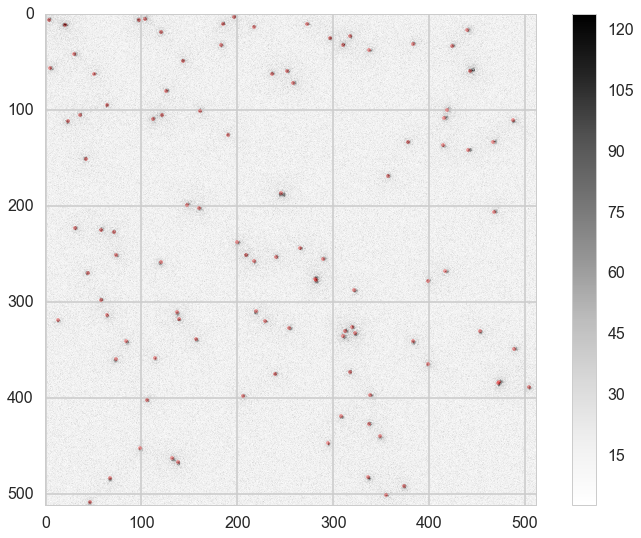

In [66]:
ysefx,ysefy = SpotEnhancingFilterLocalization(imgs)
plt.scatter(ysefx[3],ysefy[3],10,alpha=.3,color='r')
io.imshow(imgs[3],cmap='Greys')

In [67]:
ysef = {}
w = 6. #size of the window in which Imax is calculated
sigxy = 2. 

for fr in ysefx.keys():
    Imax = []
    #print 'frame=%d' %fr
    for x,y in zip(ysefx[fr],ysefy[fr]):
        minx = np.max((int(x-w/2),0))
        maxx = np.min((int(x+w/2),imgs[fr].shape[1]))
        miny = np.max((int(y-w/2),0))
        maxy = np.min((int(y+w/2),imgs[fr].shape[0]))
        Imax = Imax+ [np.max(imgs[fr][miny:maxy,minx:maxx])]
        
    Imax = np.array(Imax)
    #x,y,Imax,sigxy
    ysef[fr] = np.vstack((ysefx[fr],ysefy[fr],Imax,np.repeat(sigxy,ysefx[fr].shape[0])))

In [68]:
ysef[0]

array([[   2.,  104.,  202.,   95.,   23.,  276.,  186.,  125.,   18.,
         319.,  443.,  183.,  429.,  312.,  382.,  333.,  145.,  453.,
         248.,  440.,   52.,  241.,  255.,  124.,  420.,   64.,   42.,
         117.,  115.,   28.,  423.,  485.,  188.,  378.,  470.,  416.,
         439.,   47.,  254.,  162.,  153.,  469.,   55.,   30.,   69.,
         195.,  263.,  210.,  211.,   71.,  240.,  125.,  412.,   43.,
         399.,  325.,   62.,  133.,  219.,  143.,  234.,    5.,   61.,
         447.,  321.,  155.,  314.,  310.,  381.,  110.,   69.,  311.,
         400.,  236.,  466.,  464.,  500.,  335.,  104.,  207.,  313.,
         331.,  293.,  353.,  102.,   66.,  337.,  379.,  355.,   45.],
       [   3.,    3.,    5.,    8.,    9.,    9.,   11.,   16.,   17.,
          23.,   26.,   31.,   31.,   32.,   37.,   40.,   53.,   56.,
          59.,   59.,   60.,   67.,   69.,   77.,   92.,   98.,  102.,
         106.,  109.,  112.,  114.,  115.,  126.,  127.,  133.,  135.,
     

In [69]:
#Motion model
F = {}
Q = {}
qx = 9.
qxdot = 5.
qy = 9.
qydot = 5.
qImax = 5.
qsigxy = 5.
F[0] = np.diag(np.ones(6,dtype=float))
Q[0] = np.diag([qx,qxdot,qy,qydot,qImax,qsigxy])

#Measurement Model
H = np.zeros((4,6))
H[0,0] = 1.
H[1,2] = 1.
H[2,4] = 1.
H[3,5] = 1.

rx = 1.
ry = 1.
rImax = 5.
rsigxy = 1.
R = np.diag([rx,ry,rImax,rsigxy])

#projection matrix
Pi = np.zeros((2,4))
Pi[0,0] = 1
Pi[1,1] = 1

#Selection Matrix
Psi = np.diag([0,0,1,1])


In [70]:
def GNN(y1,y2,L=15):
    #Global nearest neighbor
    #y1,y2: # of particles X # of features matrix
    #L: distance limit
    #return connection matrix. 
    y1 = np.array(y1)
    y2 = np.array(y2)
    inf = 1E10
    N1 = y1.shape[0]
    N2 = y2.shape[0]
    #cost matrix
    C = np.zeros((N1+1,N2+1))
    #link matrix
    G = np.zeros((N1+1,N2+1),dtype=int)
    
    #initialization
    C[0,:] = L**2
    C[:,0] = L**2
    for i,yy1 in enumerate(y1):
        pi = np.sum((y2-yy1)**2,axis=1)
        pi[pi>L**2] = inf
        candj = np.where(np.sum(G[:,1:],axis=0)==0)[0]
        #print candj
        if candj.shape[0]>0:
            j = candj[np.argmin(pi[candj])]
            G[i+1,j+1] = 1
        else:
            G[i+1,0] = 1
        C[i+1,1:] = pi
        
    for j in range(y2.shape[0]):
        if np.sum(G[:,j+1])==0:
            G[0,j+1] = 1
    
    #sanity check
    goodtogo = True
    for row in G[1:,:]:
        if np.sum(row)!=1:
            goodtogo = False
    for col in G[:,1:].T:
        if np.sum(col)!=1:
            goodtogo = False
    if (not goodtogo):
        print 'error in initialization'

    #reduced cost
    stop = False
    while (not stop):
        minzIJ = 0
        #candidates
        cand = np.where((C<inf) & (G==0))
        for I,J in zip(cand[0],cand[1]):
            if (I==0) & (J==0):
                zIJ = 0
            
            if (I==0) & (J>0):
                K = np.where(G[:,J]==1)[0][0]
                zIJ = C[0,J] - C[K,J] + C[K,0]
            elif (J==0) & (I>0):
                L = np.where(G[I,:]==1)[0][0]
                zIJ = C[I,0] - C[I,L] + C[0,L]
            elif (I>0) & (J>0):
                L = np.where(G[I,:]==1)[0][0]
                K = np.where(G[:,J]==1)[0][0]
                zIJ = C[I,J] - C[I,L] - C[K,J] + C[K,L]
            
            if zIJ < minzIJ:
                minzIJ = zIJ
                minzIJ_pair = (I,J)
        if minzIJ < 0:
            I = minzIJ_pair[0]
            J = minzIJ_pair[1]
            
            if (I>0) & (J==0):
                L = np.where(G[I,:]==1)[0][0]
                G[I,L] = 0
                G[0,L] = 1
                G[I,J] = 1
                
            if (J>0) & (I==0):
                K = np.where(G[:,J]==1)[0][0]
                G[K,J]=0
                G[K,0]=1
                G[I,J]=1
            if (I>0) & (J>0):
                L = np.where(G[I,:]==1)[0][0]
                K = np.where(G[:,J]==1)[0][0]
                G[I,L] = 0
                G[K,J] = 0
                G[K,L] = 1
                G[I,J] = 1
        else:
            stop = True
    
            
    return G
                
            
                
        
    

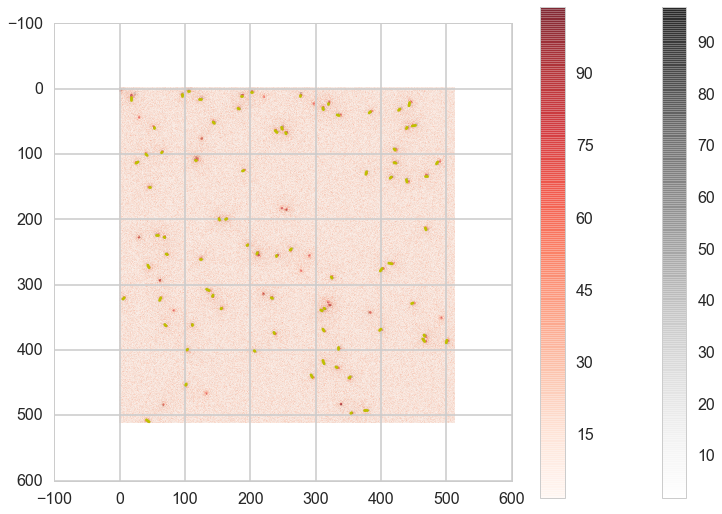

In [71]:
#GNN test
G = GNN(ysef[0][0:2,:].T,ysef[1][0:2,:].T,L=20)
io.imshow(imgs[0],cmap='Greys',alpha=0.6)
io.imshow(imgs[1],cmap='Reds',alpha=0.6)
ilist,jlist = np.where(G==1)

for i,j in zip(ilist,jlist):
    if (i==0) | (j==0):
        continue
    plt.plot([ysef[0][0,i-1],ysef[1][0,j-1]],[ysef[0][1,i-1],ysef[1][1,j-1]],'y-',alpha=1)

In [72]:
#convert trajectory dictionary to mean vector
def traj2m(traj,id_list,fr):
    id_list = np.array(id_list)
    m = np.zeros((6,id_list.shape[0]))
    for i,trajid in enumerate(id_list):
        trs = np.array(traj[trajid])
        tvec = [np.array(map(lambda x: x['t'],trs))]
        tr = trs[tvec==fr]
        m[0,i] = tr['x']
        m[1,i] = tr['xdot']
        m[2,i] = tr['y']
        m[3,i] = tr['ydot']
        m[4,i] = tr['Imax']
        m[5,i] = tr['sigxy']
    return m
    

In [73]:
def generateElliptical(Cov,gamma_p,Nc,Nj):
    #Generate Nc*Nj elliptical measurements using Cov (covariance matrix)
    Lamb,E = np.linalg.eig(Cov)

    if Lamb[0]<Lamb[1]:
        Lamb = np.roll(Lamb,1)
        E = np.roll(E,1,axis=1)

    r = np.zeros((2,2))  #semi-axes of the elliptical region
    r[:,0] = gamma_p*np.sqrt(Lamb[0])*E[:,0]
    r[:,1] = gamma_p*np.sqrt(Lamb[1])*E[:,1]
    
    p = np.zeros((2,Nc*Nj))
    ind = 0
    for c in range(1,Nc+1):
        for j in range(1,Nj+1):
            uj = [np.linalg.norm(r[:,0])*np.cos(2*math.pi*float(j)/Nj),
                  np.linalg.norm(r[:,1])*np.sin(2*math.pi*float(j)/Nj)]
            p[:,ind] = float(c)/Nc*E.dot(np.array(uj))
            ind += 1
    return p
    

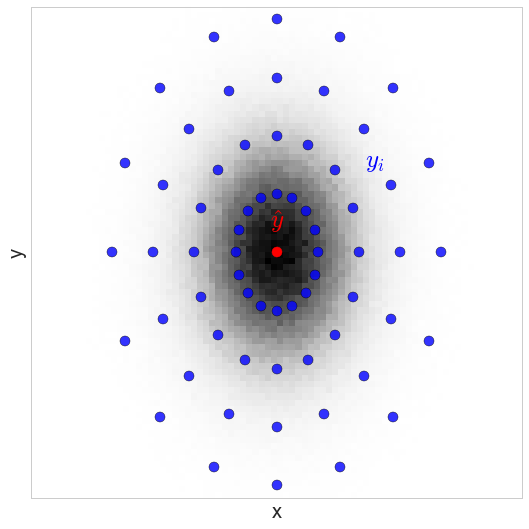

In [74]:
Cov = np.array([[20,0],[0,40]])
X = sp.random.multivariate_normal([0,0],Cov,1000000)
plt.hist2d(X[:,0],X[:,1],bins=[80,80],range=[[-20,20],[-20,20]])
p = generateElliptical(Cov,3.0,4,16)
plt.scatter(p[0,:],p[1,:],100,marker='o',alpha=0.8)
plt.scatter(0,0,100,color='r')
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.axis('image')
plt.xlabel('x',fontsize=20)
plt.ylabel('y',fontsize=20)
plt.xlim([-20,20])
plt.ylim([-20,20])
plt.text(0,2,'$\hat{y}$',color='r',fontsize=25,horizontalalignment='center')
plt.text(8,7,'$y_i$',color='b',fontsize=25,horizontalalignment='center')

In [215]:
def generateBeta(y_meas,img,w=6.,Ib=10,sign=4.0):

    beta = np.zeros(y_meas.shape[1])
    
    for i,row in enumerate(y_meas.T):
        xp = row[0]
        yp = row[1]
        Imax = row[2]
        sigxy = row[3]
        
        #define roi
        xmin = int(np.min((np.max((np.round(xp-w/2),0)),img.shape[1])))
        xmax = int(np.min((np.max((np.round(xp+w/2+1),0)),img.shape[1])))
        ymin = int(np.min((np.max((np.round(yp-w/2),0)),img.shape[0])))
        ymax = int(np.min((np.max((np.round(yp+w/2+1),0)),img.shape[0])))
        
        if (xmin == xmax) | (ymin==ymax):
            beta[i]=0
        else:
            X = np.repeat(np.array([range(xmin,xmax)]),ymax-ymin,axis=0)
            Y = np.repeat(np.array([range(ymin,ymax)]).T,xmax-xmin,axis=1)

            #print X.shape,Y.shape,img[ymin:ymax+1,xmin:xmax+1].shape
            D0 = np.linalg.norm(img[ymin:ymax,xmin:xmax]-
                                ((Imax-Ib)*np.exp(-((X-xp)**2+(Y-yp)**2)/(2*sigxy**2))+Ib))
            Db = np.linalg.norm(img[ymin:ymax,xmin:xmax]-Ib)

            beta[i] = np.exp(-(D0-Db)**2/(2*sign**2))
    
    beta = beta/np.sum(beta)
    return beta
        
        
        

In [209]:
def get_othervals(dictlist,thiskey):
    #merge all values in dictlist into a sinlge list whose keys are not 'thiskey'. will be used for updateBeta function
    dictlist = dict(dictlist)
    keys = np.array(dictlist.keys())
    if thiskey in keys:
        del dictlist[thiskey]
    return np.hstack(dictlist.values())

In [273]:
import copy
def updateBeta(y_meas_all,beta_all,sigp=3.0,deltap=3,Niter=5):
    beta_all_copy = copy.deepcopy(beta_all)
    y_meas_all = dict(y_meas_all)
    xmin = -deltap-1
    xmax = deltap+2
    ymin = -deltap-1
    ymax = +deltap+2
    X = np.repeat(np.array([range(xmin,xmax)]),ymax-ymin,axis=0)
    Y = np.repeat(np.array([range(ymin,ymax)]).T,xmax-xmin,axis=1)
    mask = X**2+Y**2<=deltap**2
    xoff,yoff = np.where(mask)
    xoff = xoff-deltap-2
    yoff = yoff-deltap-2
    height,width = imgs[0].shape

    beta0_all = dict(beta_all_copy)
    
    for it in range(Niter):
        for key in y_meas_all.keys():
            y_meas = y_meas_all[key]
            beta = beta_all_copy[key]
            beta0 = beta0_all[key]
            p_other = np.round(get_othervals(y_meas_all,key)[:2,:])
            beta_other = get_othervals(beta_all_copy,key)
            #print key,p_other.shape, beta_other.shape
            for i in range(beta.shape[0]):
                p = y_meas[:2,i]
                xp = np.round(p[0])
                yp = np.round(p[1])
                #meshgrid
                x = np.round(xoff+xp)
                y = np.round(yoff+yp)
                indmask = (x<width) & (x>=0) & (y<height) & (y>=0)
                if np.sum(indmask) == 0:
                    continue
                
                x = x[indmask]
                y = y[indmask]

                theta = 1-np.exp(-((x-xp)**2+(y-yp)**2)/sigp**2)
                theta[theta==0] = np.exp(-5)
                logtheta = np.log(theta)
                #print logtheta

                Slist = np.zeros(x.shape[0])
                for c in range(x.shape[0]):
                    xc = x[c]
                    yc = y[c]
                    logthetac = logtheta[c]
                    #measurements located at (xc,yc)
                    choosemask = (p_other[0,:]==xc) & (p_other[1,:]==yc)
                    
                    if np.sum(choosemask)==0: #no measurements at xc,yc
                        Slist[c] = 0
                    else:
                        beta_n = beta_other[choosemask]
                        Mc = np.sum(beta_n) #neighborhood map
                        Slist[c] = Mc*logthetac
                S = np.exp(np.sum(Slist))

                beta[i] = beta0[i]*S
            beta = beta/np.sum(beta)

            beta_all_copy[key] = beta
    return beta_all_copy
            

In [244]:
%%time

gamma_p = 3
Nd_thres = 2
Nc = 4
Nj = 16
mode = sp.stats.mode(imgs[0].flatten()) #background level
Ib = mode.mode[0]
print "background level=%f" %Ib
L = 15


#initialize trajectory dictionary

traj = {}
Nd = {}  #no-match counter
P = {}

for i,row in enumerate(ysef[0].T):
    x = row[0]
    y = row[1]
    Imax = row[2]
    sigxy = row[3]
    traj[i] = [{'t':0,'x':x,'y':y,'Imax':Imax,'sigxy':sigxy,'xdot':0,'ydot':0}]
    Nd[i] = 0
    #store the covariance matrix P in the last step. key is the trajectory id
    P[i] = np.diag(np.repeat(10,6))
    
nn = 0
Ptrend = {}
Ptrend[0] = P[3]
for fr in imgs.keys()[1:]:
    #construct mean vector using traj and Nd dictionaries
    id_list = np.array(Nd.keys())
    maxid = np.max(id_list) 
    id_list = id_list[np.array(Nd.values())<Nd_thres] #trajectories that haven't been terminated
    
    mprev = traj2m(traj,id_list,fr-1)
    
    Fnow = F[0]
    Qnow = Q[0]
    mhat = Fnow.dot(mprev)
    
    yhat = H.dot(mhat)
    
    #link yhat and ysef
    G = GNN(yhat[0:2].T,ysef[fr][0:2].T,L=L)
    
    #remake yhat and ysef to match their orders using G. 
    Npar = np.sum(G)#Number of particles in curret frame
    unpaired_id = np.where(G[0,1:]==1)[0]   #unpaired ysef ids
    
    phat = Pi.dot(yhat)
    psef = Pi.dot(ysef[fr])
    
    y_meas_all = {}
    beta_all = {}
    #update m with Kalman gain
    for i in range(yhat.shape[1]):
        Phat = Fnow.dot(P[id_list[i]]).dot(Fnow.T)+Qnow
        S = H.dot(Phat).dot(H.T)+R
        
        # Generate elliptical measurements
        Sp = Pi.dot(S).dot(Pi.T)
        phat_meas = np.array([phat[:,i]]).T + generateElliptical(Sp,gamma_p,Nc,Nj)  #elliptical measurements list
        yhat_meas = np.linalg.pinv(Pi).dot(phat_meas)
        y_meas = yhat_meas+np.array([Psi.dot(yhat[:,i])]).T
        y_meas = np.hstack((y_meas,np.array([yhat[:,i]]).T))
        
        if G[i+1,0]==1:
            Nd[id_list[i]] += 1
        else:
            pairid = np.where(G[i+1,1:]==1)[0][0]
            Rp = Pi.dot(R).dot(Pi.T)
            psef_meas = np.array([psef[:,pairid]]).T+generateElliptical(Rp,gamma_p,Nc,Nj)
            ysef_meas = np.linalg.pinv(Pi).dot(psef_meas)
            y_meas = np.hstack((y_meas,ysef_meas+np.array([Psi.dot(ysef[fr][:,pairid])]).T))
            y_meas = np.hstack((y_meas,np.array([ysef[fr][:,pairid]]).T))
        y_meas_all[i] = y_meas
        beta = generateBeta(y_meas,imgs[fr],Ib=Ib)
        beta_all[i] = beta
   
    for i in range(yhat.shape[1]):
        Phat = Fnow.dot(P[id_list[i]]).dot(Fnow.T)+Qnow
        S = H.dot(Phat).dot(H.T)+R
        #Kalman Filter
        K = Phat.dot(H.T).dot(np.linalg.inv(S))
        
        innov = np.sum(np.multiply(np.repeat(np.array([beta_all[i]]),4,axis=0),
                                   (y_meas_all[i]-np.array([yhat[:,i]]).T)),axis=1)
        
        m = mhat[:,i]+K.dot(innov)
        #print m
        if np.isnan(np.sum(m)):  #terminate the trajectory if it goes out of image boundary
            continue
        tr = traj[id_list[i]]
        tr = tr+[{'t':fr,'x':m[0],'xdot':m[1],'y':m[2],'ydot':m[3],'Imax':m[4],'sigxy':m[5]}]
        traj[id_list[i]] = tr
        P[id_list[i]] = (np.eye(6)-K.dot(H)).dot(Phat) 
    
    for i,idx in enumerate(unpaired_id):
        row = ysef[fr][:,idx]
        x = row[0]
        y = row[1]
        Imax = row[2]
        sigxy = row[3]
        traj[maxid+1] = [{'t':fr,'x':x,'y':y,'Imax':Imax,'sigxy':sigxy,'xdot':0,'ydot':0}]
        Nd[maxid+1] = 0
        #store the covariance matrix P in the last step. key is the trajectory id
        P[maxid+1] = np.diag(np.repeat(10,6)) 
        maxid += 1
   
    print fr
    
    if 3 in id_list:
        nn+=1
        Ptrend[nn] = P[3]
    
    

background level=18.000000
1
2
CPU times: user 6.78 s, sys: 77.5 ms, total: 6.86 s
Wall time: 7.07 s


In [80]:
from xml.dom.minidom import parseString
import datetime
nowtime = datetime.datetime.now()
xmlstr = """<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<root>
<TrackContestISBI2012 SNR="7" density="mid" generationDateTime="%s" info="Nd_thres=%f, L=%f, " scenario="VESICLE">
""" %(nowtime,Nd_thres,L)
strtoadd = ""
keys = traj.keys()
for key in keys:
    particle = traj[key]
    strtoadd = strtoadd + """<particle>
    """
    for pos in particle:
        strtoadd = strtoadd+"""<detection t="%d" x="%f" y="%f" z="0"/>
        """%(pos['t'],pos['x'],pos['y'])
    strtoadd = strtoadd+"""</particle>
    """
xmlstr = xmlstr+strtoadd+"""</TrackContestISBI2012>
</root>"""
doc = parseString(xmlstr)

In [81]:
with open("Vesicle_test1.xml", "w") as f:
    f.write( doc.toxml() )

In [116]:
traj[0]

[{'Imax': 82.0,
  'sigxy': 2.0,
  't': 0,
  'x': 2.0,
  'xdot': 0,
  'y': 3.0,
  'ydot': 0},
 {'Imax': 82.0,
  'sigxy': 2.0,
  't': 1,
  'x': 4.2531223663867541,
  'xdot': 0.0,
  'y': 5.2531231919760915,
  'ydot': 0.0},
 {'Imax': 82.0,
  'sigxy': 2.0,
  't': 2,
  'x': 0.40536098659837938,
  'xdot': 0.0,
  'y': 1.4054417374791874,
  'ydot': 0.0}]

In [118]:
Ptrend

{0: array([[10,  0,  0,  0,  0,  0],
        [ 0, 10,  0,  0,  0,  0],
        [ 0,  0, 10,  0,  0,  0],
        [ 0,  0,  0, 10,  0,  0],
        [ 0,  0,  0,  0, 10,  0],
        [ 0,  0,  0,  0,  0, 10]]),
 1: array([[  0.95  ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ],
        [  0.    ,  15.    ,   0.    ,   0.    ,   0.    ,   0.    ],
        [  0.    ,   0.    ,   0.95  ,   0.    ,   0.    ,   0.    ],
        [  0.    ,   0.    ,   0.    ,  15.    ,   0.    ,   0.    ],
        [  0.    ,   0.    ,   0.    ,   0.    ,   3.75  ,   0.    ],
        [  0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.9375]]),
 2: array([[  0.9086758 ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ],
        [  0.        ,  20.        ,   0.        ,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.9086758 ,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ,  20

In [133]:
frs = Ptrend.keys()

Px = []
Py = []
PI = []
Psig = []
Pxdot = []
Pydot = []
for fr in frs:
    Px = Px+[Ptrend[fr][0,0]]
    Py = Py+[Ptrend[fr][2,2]]
    PI = PI+[Ptrend[fr][4,4]]
    Psig = Psig+[Ptrend[fr][5,5]]
    Pxdot = Pxdot+[Ptrend[fr][1,1]]
    Pydot = Pydot+[Ptrend[fr][3,3]]

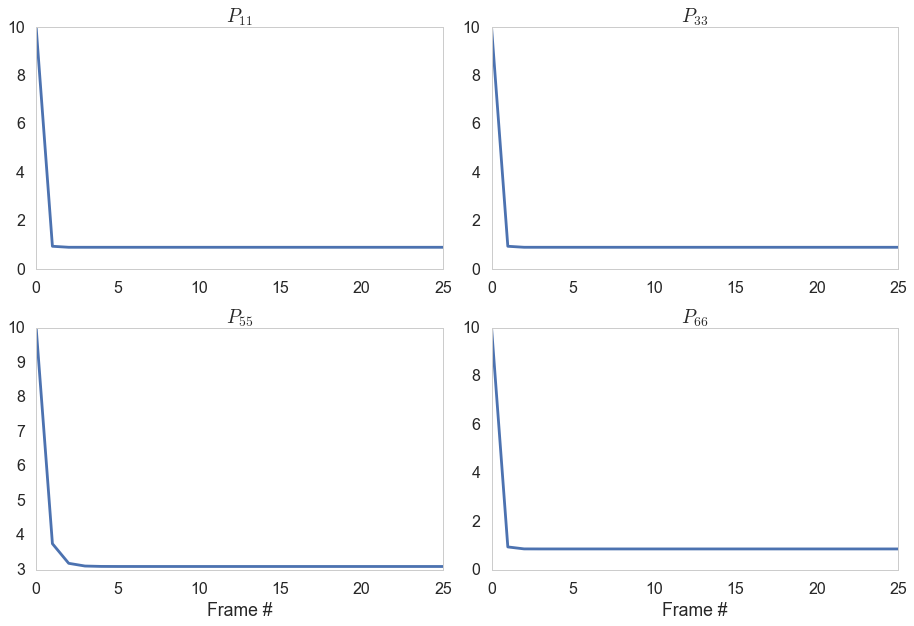

In [138]:
plt.subplot(2,2,1)
plt.plot(frs,Px)
plt.xlim([0,25])
plt.grid(False)
plt.title('$P_{11}$')

plt.subplot(2,2,2)
plt.plot(frs,Py)
plt.xlim([0,25])
plt.grid(False)
plt.title('$P_{33}$')

plt.subplot(2,2,3)
plt.plot(frs,PI)
plt.xlim([0,25])
plt.grid(False)
plt.title('$P_{55}$')
plt.xlabel('Frame #')

plt.subplot(2,2,4)
plt.plot(frs,Psig)
plt.xlim([0,25])
plt.grid(False)
plt.title('$P_{66}$')
plt.xlabel('Frame #')


plt.tight_layout()


In [140]:
TrajLengthThres = 5
Pxstat = []
PIstat = []
Psigstat = []

for key in P.keys():
    if len(traj[key]) >=5:
        Pxstat = Pxstat+[P[key][0,0]]
        PIstat = PIstat+[P[key][4,4]]
        Psigstat = Psigstat+[P[key][5,5]]

In [144]:
print np.mean(Pxstat),np.std(Pxstat)
print np.mean(PIstat),np.std(PIstat)
print np.mean(Psigstat),np.std(Psigstat)

0.908326913931 4.15165039665e-09
3.0902489641 0.000329887402329
0.854101990659 1.3379952058e-07


(array([ 587.,   43.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,   19.]),
 array([ 3.09016994,  3.09036348,  3.09055701,  3.09075054,  3.09094407,
         3.0911376 ,  3.09133114,  3.09152467,  3.0917182 ,  3.09191173,
         3.09210526]),
 <a list of 10 Patch objects>)

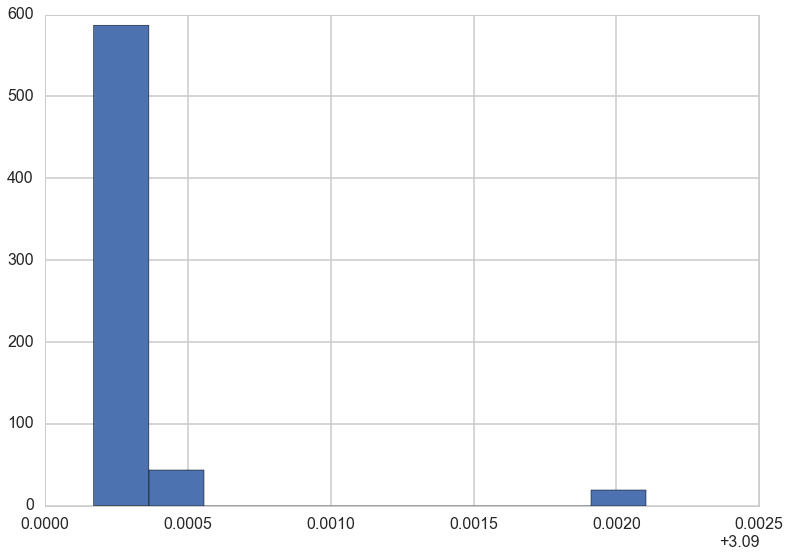

In [145]:
plt.hist(PIstat)